# House price analysis

## Setup

In [ ]:
# This takes a long time / hangs, so don't do it unless we need to.
!pip install -Uq pandas kaggle fastai scikit-learn waterfallcharts treeinterpreter dtreeviz

In [1]:
import pandas as pd
import numpy as np
import os, zipfile
from fastai import * 
from fastai.tabular.all import *
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import *
from dtreeviz.trees import *
import graphviz
from IPython.display import Image, display_svg, SVG

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
creds = '{"username":"divodivenson","key":"f0f9e3f8378e39e818097a5df978aa64"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [3]:
from kaggle import api
comp = 'house-prices-advanced-regression-techniques'
path = Path(f'../input/{comp}')
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#4) [Path('../input/house-prices-advanced-regression-techniques/test.csv'),Path('../input/house-prices-advanced-regression-techniques/data_description.txt'),Path('../input/house-prices-advanced-regression-techniques/train.csv'),Path('../input/house-prices-advanced-regression-techniques/sample_submission.csv')]

## First look at data


In [4]:
trn_path = path/'train.csv'
df = pd.read_csv(trn_path, low_memory=False)

df_test = pd.read_csv(path/'test.csv', low_memory=False)

len(df.columns), len(df_test.columns)

(81, 80)

In [5]:
# Lets get an idea of where the ordianls are
df.columns.map(lambda col: df[col].unique().size )

Index([1460,   15,    5,  111, 1073,    2,    3,    4,    4,    2,    5,    3,
         25,    9,    8,    5,    8,   10,    9,  112,   61,    6,    8,   15,
         16,    4,  328,    4,    5,    6,    5,    5,    5,    7,  637,    7,
        144,  780,  721,    6,    5,    2,    6,  753,  417,   24,  861,    4,
          3,    4,    3,    8,    4,    4,   12,    7,    4,    6,    7,   98,
          4,    5,  441,    6,    6,    3,  274,  202,  120,   20,   76,    8,
          4,    5,    5,   21,   12,    5,    9,    6,  663],
      dtype='int64')

In [6]:
def print_levels(level):
    if df[level].unique().size < 50:
        return f"{level} {df[level].unique()}\n"
    else:
        return f"{level} - Continuous\n"
    
df.columns.map(print_levels)

Index(['Id - Continuous\n',
       'MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]\n',
       'MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH']\n',
       'LotFrontage - Continuous\n', 'LotArea - Continuous\n',
       'Street ['Pave' 'Grvl']\n', 'Alley [nan 'Grvl' 'Pave']\n',
       'LotShape ['Reg' 'IR1' 'IR2' 'IR3']\n',
       'LandContour ['Lvl' 'Bnk' 'Low' 'HLS']\n',
       'Utilities ['AllPub' 'NoSeWa']\n',
       'LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']\n',
       'LandSlope ['Gtl' 'Mod' 'Sev']\n',
       'Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'\n 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'\n 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'\n 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']\n',
       'Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']\n',
       'Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']\n',
       'Bld

In [7]:
# Make note of anything that appears to follow an order, just for reference. Not exhaustive
# Not intending to input this anywhere
# Also derived from data description https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
ordinals = ['BldgType', 'HouseStyle', 'Utilities', 'ExterCond', 'ExterQual', 'Functional', 'PavedDrive']

# There are even more, lets just go with the overall Home functionality
functional = ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
df['Functional'] = df['Functional'].astype('category')
df['Functional'].cat.set_categories(functional, ordered=True)

df_test['Functional'] = df_test['Functional'].astype('category')
df_test['Functional'].cat.set_categories(functional, ordered=True)
len(df.columns), len(df_test.columns)

(81, 80)

### Dates

In [8]:
df['saledate'] = df['MoSold'].astype(str) + '/' + df['YrSold'].astype(str)
df = add_datepart(df, 'saledate')
df

/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,1,4,32,False,True,False,False,False,False,1.201824e+09
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,1,1,121,False,True,False,False,False,False,1.177978e+09
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,1,0,245,False,True,False,False,False,False,1.220227e+09
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,1,2,32,False,True,False,False,False,False,1.138752e+09
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,1,0,336,False,True,False,False,False,False,1.228090e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,1,2,213,False,True,False,False,False,False,1.185926e+09
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,1,0,32,False,True,False,False,False,False,1.264982e+09
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,1,5,121,False,True,False,False,False,False,1.272672e+09
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,1,3,91,False,True,False,True,False,False,1.270080e+09


In [9]:
# Do the same for the test dataset
df_test['saledate'] = df_test['MoSold'].astype(str) + '/' + df_test['YrSold'].astype(str)
df_test = add_datepart(df_test, 'saledate')
df_test
len(df.columns), len(df_test.columns)

/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(94, 93)

### Depedent variable

`SalePrice` is the dependent variable. We are told the evaluation is on the RMSE between the log of the predicted and actual sale price (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

Update - I'm not sure if this should be done in the submission or not

In [10]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

## Decision Tree
First lets have a go at building a plain old decision tree and submit that to Kaggle

### Test and validation set
In this case I don't see the test set contain future dates compared to the training set, so my first attempt at a validation set will just take a random sample of the training set.

In [11]:
df['YrSold'].unique(), df_test['YrSold'].unique()

(array([2008, 2007, 2006, 2009, 2010]), array([2010, 2009, 2008, 2007, 2006]))

In [12]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size=0.2)
df_train.size, df_valid.size
df_train.shape, df_valid.shape

((1168, 94), (292, 94))

In [13]:
# Need to get the index from the row in df of all the fields in df_valid
train_idx = df_train.Id.map(lambda id: df.index[df.Id == id][0])
valid_idx = df_valid.Id.map(lambda id: df.index[df.Id == id][0])
splits = (list(train_idx), list(valid_idx))

### Handle missing data and strings
Sklearn cannot handle missing data or strings.

`Categorify` is a TabularProc that replaces a column with a numeric categorical column. 

`FillMissing` is a TabularProc that replaces missing values with the median of the column

In [15]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
len(cont), len(cat)

(43, 50)

In [16]:
procs = [Categorify, FillMissing(add_col=False)]

tabular_data = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
tabular_data.xs
len(cont), len(cat)
tabular_data.xs

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,PoolArea,MiscVal,MoSold,YrSold,saleYear,saleMonth,saleWeek,saleDayofweek,saleDayofyear,saleElapsed
618,4,2,0,4,4,1,5,1,17,3,...,0,0,7,2007,2007,7,26,6,182,1.183248e+09
807,4,2,0,4,4,1,5,1,4,3,...,0,0,5,2009,2009,5,18,4,121,1.241136e+09
1032,4,2,0,1,4,1,1,1,16,3,...,0,0,11,2006,2006,11,44,2,305,1.162339e+09
1117,4,2,0,1,4,1,3,1,20,2,...,0,0,5,2008,2008,5,18,3,122,1.209600e+09
1335,4,2,0,4,4,1,5,1,15,3,...,0,0,4,2009,2009,4,14,2,91,1.238544e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,4,2,0,4,4,1,5,1,16,3,...,0,0,3,2007,2007,3,9,3,60,1.172707e+09
615,4,2,0,4,4,1,5,1,13,2,...,0,0,5,2010,2010,5,17,5,121,1.272672e+09
838,4,2,0,4,4,1,5,1,6,3,...,0,0,6,2008,2008,6,22,6,153,1.212278e+09
546,4,2,0,1,1,1,5,1,4,3,...,0,0,5,2007,2007,5,18,1,121,1.177978e+09


Need to apply the same transform to the test dataset

In [17]:
cont1, cat1 = cont_cat_split(df_test, 1)

test_data = TabularPandas(df_test, [Categorify, FillMissing(add_col=False)], cat1, cont1)
test_data.xs

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,PoolArea,MiscVal,MoSold,YrSold,saleYear,saleMonth,saleWeek,saleDayofweek,saleDayofyear,saleElapsed
0,3,2,0,4,4,1,5,1,13,2,...,0,0,6,2010,2010,6,22,1,152,1.275350e+09
1,4,2,0,1,4,1,1,1,13,3,...,0,12500,6,2010,2010,6,22,1,152,1.275350e+09
2,4,2,0,1,4,1,5,1,9,3,...,0,0,3,2010,2010,3,9,0,60,1.267402e+09
3,4,2,0,1,4,1,5,1,9,3,...,0,0,6,2010,2010,6,22,1,152,1.275350e+09
4,4,2,0,1,2,1,5,1,23,3,...,0,0,1,2010,2010,1,53,4,1,1.262304e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,5,2,0,4,4,1,5,1,11,3,...,0,0,6,2006,2006,6,22,3,152,1.149120e+09
1455,5,2,0,4,4,1,5,1,11,3,...,0,0,4,2006,2006,4,13,5,91,1.143850e+09
1456,4,2,0,4,4,1,5,1,12,3,...,0,0,9,2006,2006,9,35,4,244,1.157069e+09
1457,4,2,0,4,4,1,5,1,12,3,...,0,700,7,2006,2006,7,26,5,182,1.151712e+09


In [18]:
len(cont1), len(cat1), len(cont), len(cat)
drop_cols = np.setdiff1d(cat1, cat)
drop_cols

array([], dtype='<U20')

In [ ]:
# FastAI is adding different sets of columns for the train and test sets
# presumably because different rows have different missing values.
# Passing `add_col=False` crashes when cleaning the test data
# so I'm just going to drop the extra columns
#test_data.remove(drop_cols)

For whatever reason FillMissing decided to work so lets save the two datasets

In [ ]:
#save_pickle(path/'train.pk1', tabular_data)
#save_pickle(path/'test.pk1', test_data)

## Creating the decision tree

In [19]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

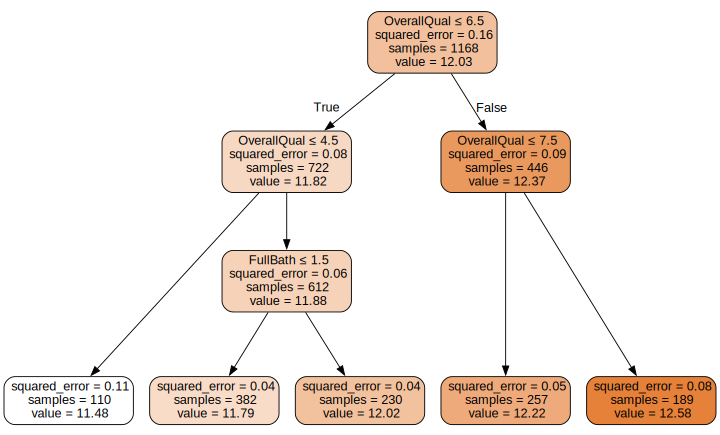

In [20]:
xs, y = tabular_data.train.xs, tabular_data.train.y # The independent and dependent params
valid_xs, valid_y = tabular_data.valid.xs, tabular_data.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=5)
m.fit(xs, y)

draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [ ]:
#dtreeviz.model(m,
#               X_train=xs, y_train=y,
#               feature_names=list(xs.columns),
#               target_name='Sale Price').view()

Create a decision tree with more nodes. We shouldn't have as many nodes as we can as this will overfit the data.

In [21]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs, y)

DecisionTreeRegressor(min_samples_leaf=25)

I'm adding the log here in the `r_mse` function instead of in the data itself. I'm unsure if this is correct but the submission sample suggests the result should just be the predicted price, not the log of it.

In [22]:
def r_mse(prediction, y): return round(math.sqrt(((np.log(prediction) - np.log(y) ) ** 2).mean()), 6)
def m_rmse(model, xs, y): return r_mse(model.predict(xs), y)    

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)
# What are these numbers, what is the kind of scale I should be thinking about
# What is a good rmse? The part that's confusing me is the book say 0.331466 is bad but 
# 0.323396 is good.
# In any case (0.165274, 0.197932) looks pretty good.

## Submit first attempt
Take a look at the submission sample to see what we need. A CSV of ID and sale price

In [23]:
sub_sample = pd.read_csv(path/'sample_submission.csv')
sub_sample

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [24]:
test_data.train

        Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley   
0     1461          20         3         80.0    11622       2      0  \
1     1462          20         4         81.0    14267       2      0   
2     1463          60         4         74.0    13830       2      0   
3     1464          60         4         78.0     9978       2      0   
4     1465         120         4         43.0     5005       2      0   
...    ...         ...       ...          ...      ...     ...    ...   
1454  2915         160         5         21.0     1936       2      0   
1455  2916         160         5         21.0     1894       2      0   
1456  2917          20         4        160.0    20000       2      0   
1457  2918          85         4         62.0    10441       2      0   
1458  2919          60         4         74.0     9627       2      0   

      LotShape  LandContour  Utilities  ...  saleDay  saleDayofweek   
0            4            4          1  ...        1

In [25]:
preds = m.predict(test_data.xs)
len(preds)

1459

In [90]:
def preds_to_csv(preds, name):
    exp_preds = list(map(lambda x: math.exp(x.item()), preds)) # Undo log
    submission = [list(t) for t in list(zip(test_data['Id'], exp_preds))]
    sub_df = pd.DataFrame(submission, columns=['Id', 'SalePrice'])
    sub_df.to_csv(name, index=False)

In [ ]:
# Zip up the ids and predictions, then transform to 2D array from Array of tuples
submission = [list(t) for t in list(zip(test_data['Id'], preds))]

# Convert to Pandas dataframe to output CSV for submission.
sub_df = pd.DataFrame(submission, columns=['Id', 'SalePrice'])
sub_df.to_csv('subm.csv', index=False)
!head subm.csv

In [ ]:
from kaggle import api
# api.competition_submit_cli('subm.csv', 'Initial decision tree', comp)


Score: 0.19112, pretty far down the leaderboard

## Random Forests
Define a function to return N decision trees

In [ ]:
??RandomForestRegressor

In [26]:
def random_forest(xs, y, n_estimators=30, max_samples=200_000,
                  max_features=0.9, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

rf = random_forest(xs, y, max_samples=len(xs))
m_rmse(rf, xs, y), m_rmse(rf, valid_xs, valid_y)

(0.007989, 0.011893)

Lets try and fine a good value for n_estimators

/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/stevendiviney/.pyenv/versions/3.9.4/lib/python3.9/site-packages/skle

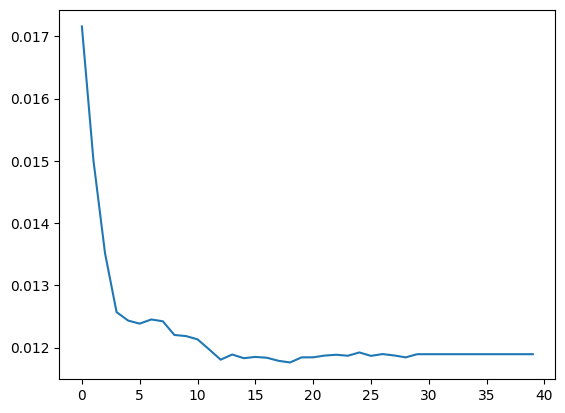

In [27]:
preds_rf = np.stack([tree.predict(valid_xs) for tree in rf.estimators_])
r_mse(preds_rf.mean(0), valid_y)
plt.plot([r_mse(preds_rf[:i+1].mean(0), valid_y) for i in range(40)])

Lets submit this set of predictions

In [28]:
type(test_data.xs)

pandas.core.frame.DataFrame

In [91]:
rf_preds = rf.predict(test_data.xs)
len(rf_preds)

1459

In [92]:
preds_to_csv(rf_preds, 'rf_subm.csv')
!head rf_subm.csv

Id,SalePrice
1461,123183.84526757344
1462,152745.79680721482
1463,171900.568814694
1464,180221.0937257547
1465,195475.52987069517
1466,184122.92866299723
1467,165942.6922579357
1468,175809.47893044035
1469,179689.32121777284


In [93]:
api.competition_submit_cli('rf_subm.csv', 'Random forest decision tree', comp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33.7k/33.7k [00:01<00:00, 26.5kB/s]


Successfully submitted to House Prices - Advanced Regression Techniques

### Improving further
Our validation set is performing worse than our training set. Why? First lets look at the out-of-bag error to see if we are overfitting by using the training data to evaluate the training (Use the training data not used by each random tree as a validation set)

In [30]:
r_mse(rf.oob_prediction_, y)

0.013031

Not sure how to interpret these results. It's about the same as our validation set and worse (a lot??) than our training set. Do this mean it's overfitting?

#### Std deviation for confidence
We can get the std-deviation of all the trees to get an idea of how confident our predictions are.

In [ ]:
rf_preds = np.stack([tree.predict(valid_xs) for tree in rf.estimators_])
rf_preds.shape

In [ ]:
rf_preds.std(0)[:10]

#### Feature importance

In [ ]:
def rf_feature_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feature_importance(rf, xs)
fi[:15]

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

Next is to cleanup redundant and unimportant features. Lets train a neural net first and see how it gets on. If we need to improve it we can revist this.

## Neural Network

In [31]:
cont_nn, cat_nn = cont_cat_split(df, max_card=9000, dep_var=dep_var)

In [ ]:
# Examine the cardinality of the categorical variables to see if there
# are any that look like duplicates and get rid of them
# None appear to be completely redundant, but from above we know 
# most are pretty useless.
#nuniq = df[cat_nn].nunique()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(nuniq)

In [32]:
procs_nn = [Categorify, FillMissing(add_col=False), Normalize]
to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)
dls = to_nn.dataloaders(1024)

In [ ]:
cont1_nn, cat1_nn = cont_cat_split(df_test, max_card=9000)

test_data_nn = TabularPandas(df_test, procs_nn, cat1_nn, cont1_nn)
#test_dls = test_data_nn.dataloaders(1024)

In [ ]:
len(cont_nn), len(cat_nn), len(cont1_nn), len(cat1_nn)

In [ ]:
len(df.columns), len(df_test.columns) #94, 93 so nothing wrong with data

In [ ]:
len(to_nn), len(test_data_nn)
to_nn.all_col_names, test_data_nn.all_col_names

In [35]:
# test_dls is the dataset we want to predict on
test_dls.show_batch()

NameError: name 'test_dls' is not defined

In [36]:
# Get the extent of our dependent variable so we can set the range of
# the regression model
y = to_nn.train.y
y.min(), y.max()

(10.47195, 13.534473)

In [44]:
# The learner is our Model
learn = tabular_learner(dls, y_range=(10, 14), n_out=1, 
                        loss_func=F.mse_loss)

SuggestedLRs(valley=0.0005754399462603033)

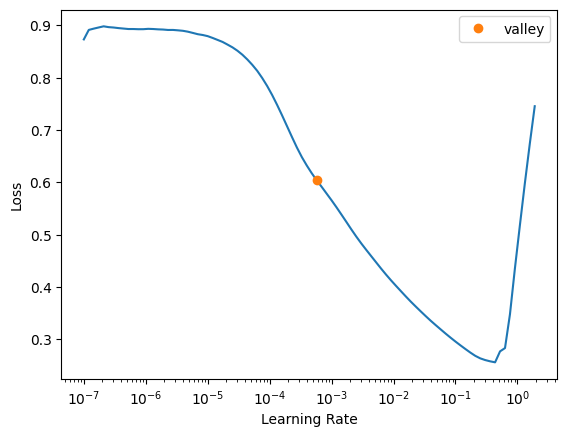

In [45]:
learn.lr_find()

In [49]:
learn.fit_one_cycle(10, 1e-1)

epoch,train_loss,valid_loss,time
0,0.005010,0.119354,00:00
1,0.004079,0.096940,00:00
2,0.016892,0.124511,00:00
3,0.026929,0.074555,00:00
4,0.059551,0.115981,00:00
5,0.078920,0.073616,00:00
6,0.074074,0.092293,00:00
7,0.070351,0.101331,00:00
8,0.065991,0.084997,00:00
9,0.062006,0.068791,00:00


In [50]:
preds,targs = learn.get_preds()
r_mse(preds, targs)

0.022256

In [ ]:
#learn.save('nn')

In [51]:
df_test.iloc[0]['Id']

1461

In [54]:
# Again having a hard time loading the test and applying the training
# transformations. FastAIs learner have a helper than can appearantly
# do it all for us, so lets try it
test_dl = learn.dls.test_dl(df_test)
#learn.get_preds(dl=test_dls)
# type(test_dl) #fastai.tabular.core.TabDataLoader
# type(test_data_nn) #fastai.tabular.core.TabularPandas
# type(test_dls) #fastai.tabular.data.TabularDataLoaders
nn_preds, _ = learn.get_preds(dl=test_dl)

In [85]:
nn_preds[0].item()
nn_preds_list = list(map(lambda x: math.exp(x.item()), nn_preds))
nn_preds_list

[82645.22724844662,
 120423.22140210841,
 232341.3146365133,
 203500.3500784215,
 167400.88835011452,
 178733.781794389,
 141149.3049134306,
 179973.51077198464,
 144384.29868327605,
 69625.06145764778,
 172629.13310943535,
 114335.30020129637,
 84595.90466178235,
 148060.66804873035,
 97447.69361546104,
 270344.9238605899,
 177238.374571097,
 310368.45707968186,
 357823.47845299944,
 435245.89228329825,
 275462.0263999894,
 211611.92760224998,
 175968.980472125,
 155894.07791193514,
 202366.06088933485,
 255011.82826941716,
 285905.1888557201,
 210584.59881437608,
 117664.47517341598,
 205989.29711336794,
 215020.80428147074,
 69697.67409429514,
 169715.1619612994,
 242397.79990779798,
 238508.26268530532,
 244567.49174468734,
 181999.84112875967,
 153156.51633944912,
 158564.24162137846,
 186486.67618706176,
 175582.5869076586,
 201625.1758439987,
 244117.75693115176,
 232524.85363002657,
 195858.9715828902,
 140324.542643906,
 185670.19221058756,
 171758.94889635465,
 129282.6429476

In [86]:
preds_to_csv(nn_preds, 'nn_subm.csv')
!head nn_subm.csv

Id,SalePrice
1461,82645.22724844662
1462,120423.22140210841
1463,232341.3146365133
1464,203500.3500784215
1465,167400.88835011452
1466,178733.781794389
1467,141149.3049134306
1468,179973.51077198464
1469,144384.29868327605


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,1,1,152,False,True,False,False,False,False,1.275350e+09
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,1,1,152,False,True,False,False,False,False,1.275350e+09
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,1,0,60,False,True,False,False,False,False,1.267402e+09
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,1,1,152,False,True,False,False,False,False,1.275350e+09
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,1,4,1,False,True,False,True,False,True,1.262304e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,1,3,152,False,True,False,False,False,False,1.149120e+09
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,1,5,91,False,True,False,True,False,False,1.143850e+09
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,1,4,244,False,True,False,False,False,False,1.157069e+09
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,1,5,182,False,True,False,True,False,False,1.151712e+09


In [87]:
api.competition_submit_cli('nn_subm.csv', 'NNv2', comp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33.5k/33.5k [00:00<00:00, 52.5kB/s]


Successfully submitted to House Prices - Advanced Regression Techniques